## Selección automática de características

Con tantas formas de crear nuevas característica, puede verse tentado a aumentar la dimensionalidad de los datos mucho más allá del número de características originales. Sin embargo, agregar más característica hace que todos los modelos sean más complejos y aumenta las posibilidades de sobreajuste.

Cuando se agregan nuevas características, o con conjuntos de datos de alta dimensión en general, puede ser una buena idea reducir la cantidad de características solo a las más útiles y descartar el resto. Esto puede conducir a modelos más simples que se generalicen mejor. Pero, ¿cómo puedes saber qué tan bueno es cada característica?

Para responder a esta pregunta hay 3 estrategias:

* Estadística univariada
* Selección basada en modelos
* Selección iterativa

Todos estos métodos son métodos supervisados, lo que significa que necesitan un objetivo para ajustar el modelo. Esto significa que debemos dividir los datos en conjuntos de entrenamiento y prueba, y ajustar la selección de características solo en la parte de entrenamiento de los datos.

### Estadística univariada 

En estadísticas univariadas, calculamos si existe una relación estadísticamente significativa entre cada característica y el objetivo. Luego se seleccionan las características que están relacionadas con la mayor confianza. En el caso de la clasificación, esto también se conoce como análisis de varianza (ANOVA).

Una propiedad clave de estas pruebas es que son univariadas, lo que significa que solo consideran cada característica individualmente. En consecuencia, una característica se descartará si solo es informativa cuando se combina con otra característica. Las pruebas univariadas a menudo son muy rápidas de computar y no requieren construir un modelo. Por otro lado, son completamente independientes del modelo que puede aplicar después de la selección de características.

Para utilizar la selección de características univariadas en scikit-learn, debemos elegir una prueba, por lo general ya sea `f_classif` ( predeterminada) para la clasificación o `f_regression` para la regresión, y un método para descartar las características en función de los valores `p` determinados en la prueba.

Todos los métodos para descartar parámetros usan un umbral para descartar todas las características con un valor `p` demasiado alto (lo que significa que es poco probable que estén relacionadas con el objetivo).

Los métodos difieren en cómo calculan este umbral, siendo los más simples `SelectKBest`, que selecciona un número fijo `k `de características, y `SelectPercentile`, que selecciona un porcentaje fijo de características.

#### Ejemplo

Vamos a aplicar la selección de características para la clasificación en el conjunto de datos de `cancer`. Para hacer la tarea un poco más difícil, agregaremos algunas características de ruido no informativo a los datos. Esperamos que la selección de características pueda identificar las características que no son informativas y eliminarlas:


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

# conseguimos numeros aleatorios deterministicos 
rng = np.random.RandomState(42)
ruido = rng.normal(size=(len(cancer.data), 50))

# agregamos la caracteristica de ruido a los datos
# las primeras  30 caracteristicas son del conjunto de datos, las proximo 50 son ruido
X_w_ruido = np.hstack([cancer.data, ruido])

# Dividimos los datos 
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X_w_ruido, cancer.target, random_state=0, test_size=.5)

# usamos f_classif y  SelectPercentile para seleccionar 50% de caracteristicas
seleccion = SelectPercentile(percentile=50)
seleccion.fit(X_entrenamiento, y_entrenamiento)

# transformamos el conjunto de entrenamiento 
X_entrenamiento_seleccionado = seleccion.transform(X_entrenamiento)

print("Dimension de X_entrenamiento: {}".format(X_entrenamiento.shape))
print("Dimension de X_entrenamiento_seleccionado: {}".format(X_entrenamiento_seleccionado.shape))

Dimension de X_entrenamiento: (284, 80)
Dimension de X_entrenamiento_seleccionado: (284, 40)


Como se puede ver, la cantidad de características se redujo de 80 a 40 (50 por ciento del número original de características). Podemos averiguar qué características se han seleccionado utilizando el método `get_support`, que devuelve una máscara booleana de las características seleccionadas:

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


([], <a list of 0 Text yticklabel objects>)

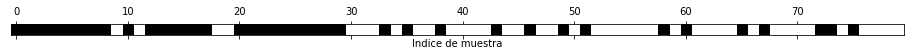

In [6]:
mascara = seleccion.get_support()
print(mascara)
# visualizamos la mascara -- negro es True, white es False
plt.matshow(mascara.reshape(1, -1), cmap='gray_r')
plt.xlabel("Indice de muestra")
plt.yticks(())

Como se puede ver en la visualización de la máscara, la mayoría de las características seleccionadas son las características originales  y la mayoría de las características de ruido fueron eliminadas. Sin embargo, la recuperación de las características originales no es perfecta. Comparemos el rendimiento de la regresión logística en todas las características con el rendimiento utilizando solo las características seleccionadas:

In [7]:
from sklearn.linear_model import LogisticRegression

# transformamos los datos pruebas 
X_prueba_seleccionada = seleccion.transform(X_prueba)

lr = LogisticRegression()
lr.fit(X_entrenamiento, y_entrenamiento)
print("Puntuacion con todas las caracteristicas: {:.3f}".format(lr.score(X_prueba, y_prueba)))
lr.fit(X_entrenamiento_seleccionado, y_entrenamiento)
print("Puntuaciones con solo caracteristicas seleccionada: {:.3f}".format(
    lr.score(X_prueba_seleccionada, y_prueba)))

Puntuacion con todas las caracteristicas: 0.930
Puntuaciones con solo caracteristicas seleccionada: 0.940


En este caso, eliminar las características de ruido mejoró el rendimiento, aunque se perdieron algunas de las características originales. Este fue un ejemplo artificial muy simple, y los resultados en datos reales suelen ser mixtos. La selección de características univariadas aún puede ser muy útil;  sin embargo, si existe una cantidad tan grande de características que construir un modelo en ellas es inviable, o si se sospecha que muchas características son completamente desinformativas.



### Selección de características basadas en modelos

La selección de características basada en el modelo utiliza un modelo supervisado de machine learning para juzgar la importancia de cada característica y guarda solo las más importantes. El modelo supervisado que se utiliza para la selección de características no necesita ser el mismo modelo que se utiliza para el modelado final supervisado. 

El modelo de selección de características debe proporcionar alguna medida de importancia para cada característica, de modo que puedan clasificarse según esta medida. Los árboles de decisión y los modelos basados en árbol de decisión proporcionan un atributo `feature_importances_`, que codifica directamente la importancia de cada característica. Los modelos lineales tienen coeficientes, que también se pueden usar para capturar las características importancias al considerar los valores absolutos. Como se vió anteriormente, los modelos lineales con penalización L1 aprenden coeficientes dispersos, que solo usan un pequeño subconjunto de características. Esto se puede ver como una forma de selección de características para el modelo en sí, pero también se puede usar como un paso de preprocesamiento para seleccionar características para otro modelo.

A diferencia de la selección univariada, la selección basada en modelos considera todas las características a la vez, y de esta manera puede capturar las interacciones (si el modelo puede capturarlas). Para usar la selección de características basada en modelos, necesitamos usar el transformador SelectFromModel:

In [8]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
seleccion= SelectFromModel(
RandomForestClassifier(n_estimators=100, random_state=42),threshold="median")

La clase SelectFromModel selecciona todas las características que tienen una medida de importancia de la característica (según lo provisto por el modelo supervisado) mayor que el umbral provisto. Para obtener un resultado comparable al que obtuvimos con la selección de funciones univariadas, usamos la mediana como un umbral, de modo que se seleccionará la mitad de las características.

#### Ejemplo

Usamos un clasificador de bosque aleatorio con 100 árboles para calcular la importancia de las características. Este es un modelo bastante complejo y mucho más poderoso que el uso de pruebas univariadas. Ajustemos el modelo:


In [9]:
seleccion.fit(X_entrenamiento, y_entrenamiento)
X_entrenamiento_l1 = seleccion.transform(X_entrenamiento)
print("Dimension de X_entrenamiento: {}".format(X_entrenamiento.shape))
print("Dimension de X_entrenamiento_l1: {}".format(X_entrenamiento_l1.shape))

Dimension de X_entrenamiento: (284, 80)
Dimension de X_entrenamiento_l1: (284, 40)


Nuevamente, podemos echar un vistazo a las características que fueron seleccionadas:

([], <a list of 0 Text yticklabel objects>)

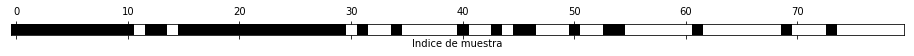

In [10]:
mascara = seleccion.get_support()
# visualizamos la mascara -- negro es True, white es False
plt.matshow(mascara.reshape(1, -1), cmap='gray_r')
plt.xlabel("Indice de muestra")
plt.yticks(())

Esta vez, todas menos dos de las características originales fueron seleccionadas. Debido a que especificamos seleccionar 40 características, algunas de las características de ruido también se seleccionan. Echemos un vistazo al rendimiento:


In [12]:
X_prueba_l1 = seleccion.transform(X_prueba)
puntuacion = LogisticRegression().fit(X_entrenamiento_l1, y_entrenamiento).score(X_prueba_l1, y_prueba)
print("Puntuacion conjunto de prueba: {:.3f}".format(puntuacion))

Puntuacion conjunto de prueba: 0.951


### Selección de características iterativas

En las pruebas univariadas no usamos ningún modelo, mientras que en la selección basada en modelos usamos un modelo único para seleccionar las características. En la selección de características iterativas, se crean una serie de modelos, con diferentes números de características. Hay dos métodos básicos: comenzar sin características y agregar características una por una hasta que se alcance algún criterio de detención, o comenzar con todas las características y eliminar características una por una hasta que se alcance un criterio de detención.

Debido a que se construyen una serie de modelos, estos métodos son  computacionalmente más costosos que los métodos anteriores. Un método particular de este tipo es la eliminación recursiva de características (RFE), que comienza con todas las características, construye un modelo y descarta la característica menos importante según el modelo.

Luego, se crea un nuevo modelo utilizando todas las características consideras y así sucesivamente hasta que solo quede un número predeterminado de características. Para que esto funcione, el modelo utilizado para la selección debe proporcionar alguna forma de determinar la importancia de las características, como fue el caso de la selección basada en modelos.

#### Ejemplo

Aquí, usamos el mismo modelo de bosque aleatorio que utilizamos anteriormente y obtenemos los resultados que se muestran en la siguiente figura:

([], <a list of 0 Text yticklabel objects>)

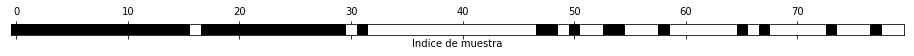

In [13]:
from sklearn.feature_selection import RFE
seleccion = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
n_features_to_select=40)
seleccion.fit(X_entrenamiento, y_entrenamiento)

mascara = seleccion.get_support()
# visualizamos la mascara -- negro es True, white es False
plt.matshow(mascara.reshape(1, -1), cmap='gray_r')
plt.xlabel("Indice de muestra")
plt.yticks(())

La selección de características mejoró en comparación con la selección univariada y basada en modelos, pero aún se perdió una característica. La ejecución de este código también lleva mucho más tiempo que la de la selección basada en modelos, porque un modelo de bosque aleatorio se entrena 40 veces, una para cada característica que se descarta.

Probemos la precisión del modelo de regresión logística al usar RFE para la selección de características:

In [14]:
X_entrenamiento_rfe= seleccion.transform(X_entrenamiento)
X_prueba_rfe= seleccion.transform(X_prueba)
puntuacion = LogisticRegression().fit(X_entrenamiento_rfe, y_entrenamiento).score(X_prueba_rfe, y_prueba)
print("Prueba del conjunto de datos: {:.3f}".format(puntuacion))

Prueba del conjunto de datos: 0.951


También podemos usar el modelo utilizado dentro del RFE para hacer predicciones. Esto usa solo el conjunto de características que se seleccionó:

In [16]:
print("Puntuacion del conjunto de datos: {:.3f}".format(seleccion.score(X_prueba, y_prueba)))

Puntuacion del conjunto de datos: 0.951


Aquí, el rendimiento del bosque aleatorio utilizado dentro del RFE es el mismo que el logrado al entrenar un modelo de regresión logística sobre las características seleccionadas. En otras palabras, una vez que hemos seleccionado las características correctas, el modelo lineal funciona tan bien como el bosque aleatorio.

###  Utilizando conocimiento experto

La ingeniería de características suele ser un lugar importante para utilizar el conocimiento experto para una aplicación en particular. Si bien el objetivo del machine learning en muchos casos es evitar tener que crear un conjunto de reglas diseñadas por expertos, eso no significa que se deba descartar el conocimiento previo de la aplicación o el dominio. A menudo, los expertos de dominio pueden ayudar a identificar características útiles que son mucho más informativas que la representación inicial de los datos.

#### Ejemplo

Veamos un caso particular de uso de conocimiento experto, aunque en este caso podría llamarse con más razón "sentido común". La tarea es predecir el alquiler de bicicletas frente a la casa de Andreas.

En Nueva York, Citi Bike opera una red de estaciones de alquiler de bicicletas con un sistema de suscripción. Las estaciones están por toda la ciudad y ofrecen una manera conveniente de moverse. Los datos de alquiler de bicicletas se hacen públicos en forma anónima y se han analizado de varias maneras. La tarea que queremos resolver es predecir para una hora y un día determinado cuántas personas van a alquilar una bicicleta frente a la casa de Andreas, así que él sabe si quedará alguna bicicleta para el.

Primero cargamos los datos de agosto de 2015 para esta estación en particular como un data frame de pandas. Volvemos a muestrear los datos en intervalos de tres horas para obtener las principales tendencias para cada día:


In [40]:
def cargar_citibike():
    datos1 = pd.read_csv("citibike.csv")
    datos1['one'] = 1
    datos1['starttime'] = pd.to_datetime(datos1.starttime)
    datos_inicio = datos1.set_index("starttime")
    datos_remuestreados= datos_inicio.resample("3h").sum().fillna(0)
    return datos_remuestreados.one


In [41]:
citibike = cargar_citibike()

In [42]:
print("Datos de City Bike :\n{}".format(citibike.head()))

Datos de City Bike :
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


El siguiente ejemplo muestra una visualización de las frecuencias de alquiler para todo el mes :

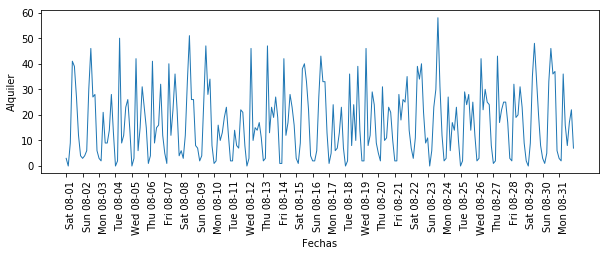

In [47]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Fechas")
plt.ylabel("Alquiler")
plt.show()

Al observar los datos, podemos distinguir claramente el día y la noche para cada intervalo de 24 horas. Los patrones para los días de la semana y los fines de semana también parecen ser bastante diferentes. Al evaluar una tarea de predicción en una serie de tiempo como esta, generalmente queremos aprender del pasado y predecir el futuro. Esto significa que al dividir los datos en un  conjunto de entrenamiento y un conjunto de pruebas, queremos utilizar todos los datos hasta una fecha determinada como el conjunto de entrenamiento y todos los datos pasados a esa fecha como el conjunto de prueba.

La única característica que estamos utilizando en nuestra tarea de predicción es la fecha y la hora en que se produjo una determinada cantidad de alquileres. Por lo tanto, la función de entrada es la fecha y la hora, por ejemplo, 2015-08-01 00: 00: 00, y el resultado es el número de alquileres en las siguientes tres horas (tres en este caso, de acuerdo con el DataFrame).

Una forma  común de como las fechas se almacenen en las computadoras es utilizando el tiempo POSIX, que es el número de segundos desde enero de 1970 a las 00:00:00 (también conocido como el comienzo del tiempo Unix). Como primer intento, podemos usar esta característica como representación de datos:

In [30]:
# extraemos los valores objetivo (numero de alquileres)
y = citibike.values
# convertimos las fechas  en tiempo POSIX usando "% s"
X = citibike.index.strftime("%s").astype("int").reshape(-1, 1)

Primero definimos una función para dividir los datos en conjuntos de entrenamiento y prueba, construimos  el modelo y visualizamos el resultado:

In [45]:
# usamos los primeros 184 puntos de datos para entrenamiento, el resto para pruebas
n_entrenamiento = 184

# funcion para evaluar y graficar un regresor en un conjunto de características determinado
def evaluacion_caracteristica(caracteristica, objetivo, regresor):
    # dividimos las características dadas en un conjunto de entrenamiento y de prueba
    X_entrenamiento, X_prueba = caracteristica[:n_entrenamiento], caracteristica[n_entrenamiento:]
    # dividimos  la matriz objetivo
    y_entrenamiento, y_prueba = objetivo[:n_entrenamiento], objetivo[n_entrenamiento:]
    regresor.fit(X_entrenamiento, y_entrenamiento)
    print("Conjunto de prueba R^2: {:.2f}".format(regresor.score(X_prueba, y_prueba)))
    y_pred = regresor.predict(X_prueba)
    y_pred_entrenamiento = regresor.predict(X_entrenamiento)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")
    plt.plot(range(n_entrenamiento), y_entrenamiento, label="entrenamiento")
    plt.plot(range(n_entrenamiento, len(y_prueba) + n_entrenamiento), y_prueba, '-', label="prueba")
    plt.plot(range(n_entrenamiento), y_pred_entrenamiento, '--', label="prediccion de entrenamiento")

    plt.plot(range(n_entrenamiento, len(y_prueba) + n_entrenamiento), y_pred, '--',
             label="prediccion de prueba")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Fechas")
    plt.ylabel("Rentas")

Vimos anteriormente que los bosques aleatorios requieren muy poco preprocesamiento de los datos, lo que hace que este parezca un buen modelo para empezar. Utilizamos la característica de tiempo POSIX `X`  y pasamos un regresor forestal aleatorio a nuestra función `evaluacion_caracteristica`.

Conjunto de prueba R^2: -0.04


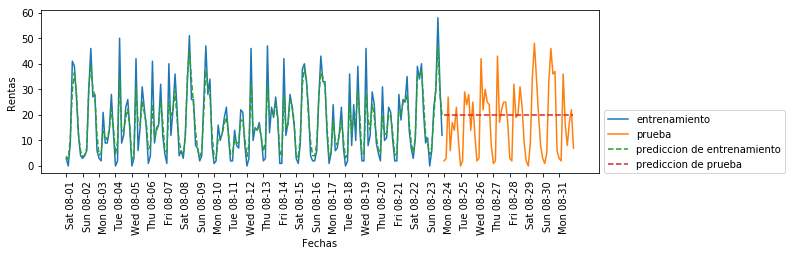

In [46]:
from sklearn.ensemble import RandomForestRegressor
regresor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
evaluacion_caracteristica(X, y, regresor)

Las predicciones en el conjunto de entrenamiento son bastante buenas, como es habitual en los bosques aleatorios. Sin embargo, para el conjunto de prueba, se predice una línea constante. El $R^2$ es -0.03, lo que significa que no aprendimos nada. ¿Que pasó?

El problema radica en la combinación de nuestra característica y el bosque aleatorio. El valor de la característica de tiempo POSIX para el conjunto de prueba está fuera del rango de los valores de característica en el conjunto de entrenamiento: los puntos en el conjunto de prueba tienen marcas de tiempo que son posteriores a todos los puntos en el conjunto de entrenamiento. Los árboles, y por lo tanto los bosques aleatorios, no pueden extrapolar a rangos de características fuera del conjunto de entrenamiento. El resultado es que el modelo simplemente predice el valor objetivo del punto más cercano en el conjunto de entrenamiento, que es la última vez que observó datos.

Claramente podemos hacerlo mejor que esto. Aquí es donde entra nuestro "conocimiento experto". Al observar las cifras de alquiler en los datos de entrenamiento, dos factores parecen ser muy importantes: la hora del día y el día de la semana. Entonces, agreguemos estas dos características. Realmente no podemos aprender nada de la hora POSIX, así que descartamos esa característica. Primero, usemos solo la hora del día.

Como muestra la siguiente figura, ahora las predicciones tienen el mismo patrón para cada día de la semana:

Conjunto de prueba R^2: 0.60


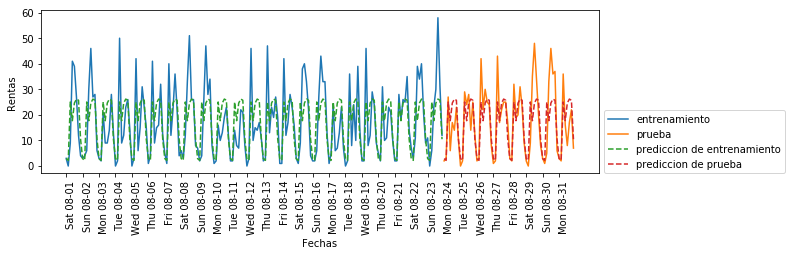

In [49]:
X_hora = citibike.index.hour.values.reshape(-1, 1)
evaluacion_caracteristica(X_hora, y, regresor)

El R2 ya es mucho mejor, pero las predicciones claramente pasan por alto el patrón semanal. Ahora agreguemos el día de la semana:

Conjunto de prueba R^2: 0.84


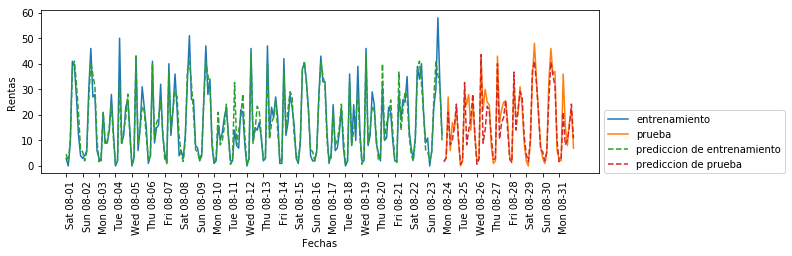

In [50]:
X_hora_semana  = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1), citibike.index.hour.values.reshape(-1, 1)])
evaluacion_caracteristica(X_hora_semana, y, regresor)

Ahora tenemos un modelo que captura el comportamiento periódico al considerar el día de la semana y la hora del día. Se tiene un $R^2$ de 0,84 y muestra un buen rendimiento predictivo. Lo que este modelo probablemente esté aprendiendo es la cantidad promedio de alquileres para cada combinación de día de la semana y hora del día a partir de los primeros 23 días de agosto. Esto en realidad no requiere un modelo complejo como un bosque aleatorio, así que vamos a probar con un modelo más simple `LinearRegression`:

Conjunto de prueba R^2: 0.13


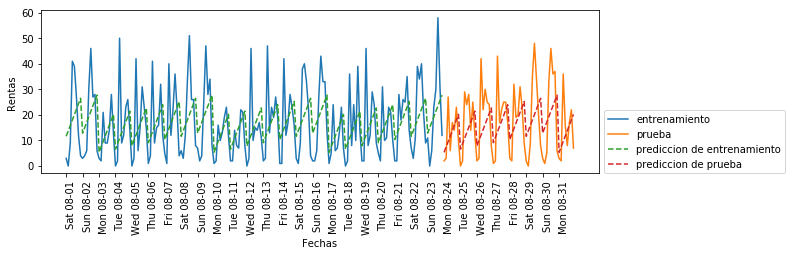

In [51]:
from sklearn.linear_model import LinearRegression
evaluacion_caracteristica(X_hora_semana, y, LinearRegression())

`LinearRegression` funciona mucho peor, y el patrón periódico parece extraño. La razón de esto es que codificamos el día de la semana y la hora del día usando enteros, que se interpretan como variables categóricas. Por lo tanto, el modelo lineal solo puede aprender una función lineal de la hora del día y aprendió que más adelante en el día, hay más alquileres. Sin embargo, los patrones son mucho más complejos que eso. Podemos capturar esto interpretando los enteros como variables categóricas, transformándolos usando `One HotEncoder`:

Conjunto de prueba R^2: 0.62


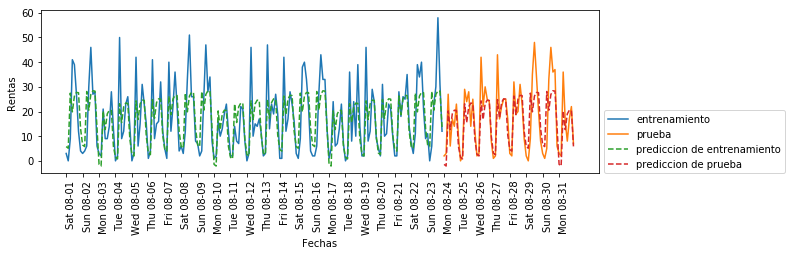

In [54]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
enc = OneHotEncoder()
X_hora_semana_onehot = enc.fit_transform(X_hora_semana).toarray()
evaluacion_caracteristica(X_hora_semana_onehot, y, Ridge())

Esto nos da una coincidencia mucho mejor que la codificación de características continuas. Ahora el modelo lineal aprende un coeficiente para cada día de la semana y un coeficiente para cada momento del día. Eso significa que el patrón de "hora del día" se comparte durante todos los días de la semana.

Al usar las características de interacción, podemos permitir que el modelo aprenda un coeficiente para cada combinación de día y hora del día.

Conjunto de prueba R^2: 0.85


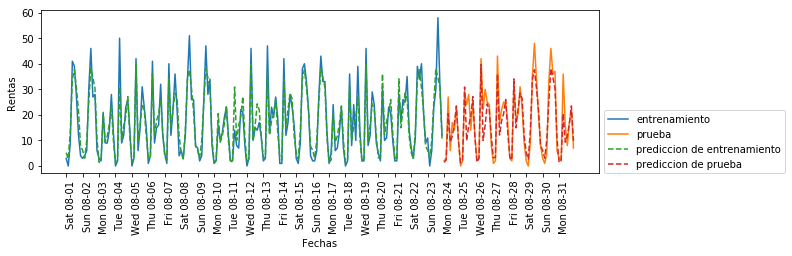

In [56]:
from sklearn.preprocessing import PolynomialFeatures

tranformacion_polinomial = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hora_semana_onehot_polinomio = tranformacion_polinomial.fit_transform(X_hora_semana_onehot)
lr = Ridge()
evaluacion_caracteristica(X_hora_semana_onehot_polinomio, y, lr)

Esta transformación finalmente produce un modelo que funciona de manera similar al bosque aleatorio. Un gran beneficio de este modelo es que es muy claro lo que se aprende: un coeficiente para cada día y hora. Simplemente podemos dibujar los coeficientes aprendidos por el modelo, algo que no sería posible para el bosque aleatorio.

Primero, creamos nombres de las características para las características de hora y día:

In [57]:
hora = ["%02d:00" % i for i in range(0, 24, 3)]
dia= ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
caracteristicas = dia + hora

A continuación, nombramos todas las características de interacción extraídas por `PolynomialFeatures`, utilizando el método `get_feature_names` y conservamos solo las características con coeficientes distintos de cero:

In [58]:
polinomio_caracteristica = tranformacion_polinomial.get_feature_names(caracteristicas)
carateristicas_distinta_cero = np.array(polinomio_caracteristica)[lr.coef_ != 0]
coef_distinto_cero = lr.coef_[lr.coef_ != 0]

Ahora podemos visualizar los coeficientes aprendidos por el modelo lineal, como se ve en la siguiente figura:

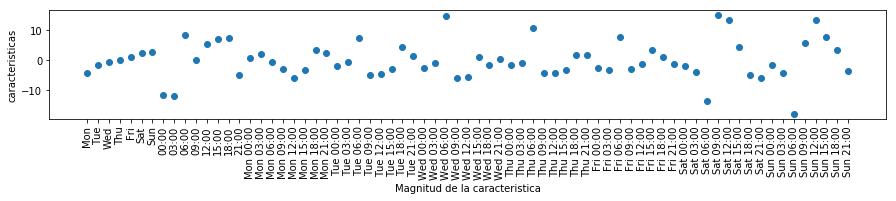

In [60]:
plt.figure(figsize=(15, 2))
plt.plot(coef_distinto_cero, 'o')
plt.xticks(np.arange(len(coef_distinto_cero)), carateristicas_distinta_cero, rotation=90)
plt.xlabel("Magnitud de la caracteristica")
plt.ylabel("caracteristicas")
plt.show()